Sujana Shahrin     ID- 2220836


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import shutil

def manual_gamma_transformation(image, gamma):
    """
    Applies Gamma Transformation manually to an image without using
    built-in gamma correction functions.

    Formula: I_out = I_in ^ gamma

    Steps:
    1. Normalize pixel values from [0, 255] to [0.0, 1.0].
    2. Apply the power law (gamma) transformation.
    3. Scale values back to [0, 255].

    Args:
        image (numpy.ndarray): Input image (grayscale or color).
        gamma (float): Gamma value. < 1 brightens, > 1 darkens.

    Returns:
        numpy.ndarray: Gamma corrected image.
    """

    img_normalized = image.astype(np.float32) / 255.0
    img_corrected = np.power(img_normalized, gamma)

    # Scale back to range [0, 255]
    img_rescaled = img_corrected * 255.0


    img_output = np.clip(img_rescaled, 0, 255).astype(np.uint8)

    return img_output

def process_mri_dataset(input_root, output_root, gamma):
    """
    Traverses the input dataset structure, applies Gamma Transformation
    to MRI images, and copies MASK images unchanged.
    """

    print(f"Starting processing with Gamma = {gamma}...")

    for root, dirs, files in os.walk(input_root):

        rel_path = os.path.relpath(root, input_root)
        current_output_dir = os.path.join(output_root, rel_path)

        if not os.path.exists(current_output_dir):
            os.makedirs(current_output_dir)

        if os.path.basename(root) == 'MRI':
            print(f"Processing MRI folder: {rel_path}")
            for filename in files:
                if filename.lower().endswith('.png'):

                    input_path = os.path.join(root, filename)
                    output_path = os.path.join(current_output_dir, filename)

                    img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)

                    if img is not None:

                        gamma_img = manual_gamma_transformation(img, gamma)

                        cv2.imwrite(output_path, gamma_img)
                    else:
                        print(f"Warning: Could not read image {input_path}")

        elif os.path.basename(root) == 'MASK':
            print(f"Copying MASK folder: {rel_path}")
            for filename in files:

                input_path = os.path.join(root, filename)
                output_path = os.path.join(current_output_dir, filename)
                shutil.copy2(input_path, output_path)

    print("\nProcessing complete. Processed dataset saved to:", output_root)

# --- Configuration ---

# Input and Output Directories
input_folder = "/content/drive/MyDrive/Dataset/Processed_2D_dataset_split/Train"
output_folder = "/content/drive/MyDrive/Dataset/Processed_2D_dataset_split"

# gamma < 1 is selected to brighten dark regions and enhance hypointense lesions.
# values for MRI enhancement are 0.5 to 0.8.
gamma_value = 0.5

# Run the processing
if __name__ == "__main__":
    if os.path.exists(input_folder):
        process_mri_dataset(input_folder, output_folder, gamma_value)
    else:
        print(f"Error: Input folder '{input_folder}' not found.")

Starting processing with Gamma = 0.5...
Processing MRI folder: BCBM-RadioGenomics-9-0/MRI
Copying MASK folder: BCBM-RadioGenomics-9-0/MASK
Processing MRI folder: BCBM-RadioGenomics-5-1/MRI
Copying MASK folder: BCBM-RadioGenomics-5-1/MASK
Copying MASK folder: BCBM-RadioGenomics-8-0/MASK
Processing MRI folder: BCBM-RadioGenomics-8-0/MRI
Processing MRI folder: BCBM-RadioGenomics-5-2/MRI
Copying MASK folder: BCBM-RadioGenomics-5-2/MASK
Processing MRI folder: BCBM-RadioGenomics-7-0/MRI
Copying MASK folder: BCBM-RadioGenomics-7-0/MASK
Processing MRI folder: BCBM-RadioGenomics-3-0/MRI
Copying MASK folder: BCBM-RadioGenomics-3-0/MASK
Processing MRI folder: BCBM-RadioGenomics-5-0/MRI
Copying MASK folder: BCBM-RadioGenomics-5-0/MASK
Processing MRI folder: BCBM-RadioGenomics-13-0/MRI
Copying MASK folder: BCBM-RadioGenomics-13-0/MASK
Processing MRI folder: BCBM-RadioGenomics-14-1/MRI
Copying MASK folder: BCBM-RadioGenomics-14-1/MASK
Processing MRI folder: BCBM-RadioGenomics-13-2/MRI
Copying MASK f

In [ ]:
import os
import cv2
import numpy as np
import shutil

def manual_box_filter(image, kernel_size=3):
    """
    Applies a Box Filter manually to an image without using built-in
    convolution functions.

    Mechanism: Uniform Local Averaging.
    Each pixel is replaced by the average value of its neighborhood.

    Args:
        image (numpy.ndarray): Input 8-bit grayscale image.
        kernel_size (int): Size of the square kernel (odd number, e.g., 3, 5).
                           Defaults to 3 for best trade-off between noise
                           reduction and preservation of small metastatic foci.

    Returns:
        numpy.ndarray: Filtered image.
    """

    h, w = image.shape

    pad = kernel_size // 2

    padded_img = np.pad(image, ((pad, pad), (pad, pad)), mode='reflect')

    # Initialize output image
    output_img = np.zeros_like(image)

    # Total number of pixels in the kernel (9 for 3x3)
    kernel_area = kernel_size * kernel_size


    for i in range(h):
        for j in range(w):

            roi = padded_img[i:i + kernel_size, j:j + kernel_size]

            # Calculate the sum of pixels in the ROI
            pixel_sum = np.sum(roi)


            average_value = int(pixel_sum / kernel_area)

            # Assign to output
            output_img[i, j] = average_value

    return output_img

def process_dataset_box_filter(input_root, output_root, kernel_size=3):
    """
    Traverses the dataset, applies Manual Box Filter to MRI images,
    and copies MASK images unchanged.
    """
    print(f"Starting Box Filter processing (Kernel: {kernel_size}x{kernel_size})...")

    for root, dirs, files in os.walk(input_root):
        # Determine relative path to mirror structure
        rel_path = os.path.relpath(root, input_root)
        current_output_dir = os.path.join(output_root, rel_path)

        # Create output directory
        if not os.path.exists(current_output_dir):
            os.makedirs(current_output_dir)

        # Check folder type
        folder_name = os.path.basename(root)

        if folder_name == 'MRI':
            print(f"Processing MRI folder: {rel_path}")
            for filename in files:
                if filename.lower().endswith('.png'):
                    input_path = os.path.join(root, filename)
                    output_path = os.path.join(current_output_dir, filename)

                    # Read image as grayscale (8-bit)
                    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

                    if img is not None:
                        # Apply Manual Box Filter
                        filtered_img = manual_box_filter(img, kernel_size)

                        # Save result
                        cv2.imwrite(output_path, filtered_img)
                    else:
                        print(f"Warning: Could not read {input_path}")

        elif folder_name == 'MASK':
            print(f"Copying MASK folder: {rel_path}")
            for filename in files:
                input_path = os.path.join(root, filename)
                output_path = os.path.join(current_output_dir, filename)

                # Copy mask unchanged
                shutil.copy2(input_path, output_path)

    print(f"\nProcessing Complete. Saved to: {output_root}")

# --- Configuration ---
input_folder = "/content/drive/MyDrive/Dataset/Processed_2D_dataset_split/Train"
output_folder = "/content/drive/MyDrive/Dataset/Processed_2D_dataset_split/Train_Box_filter"

KERNEL_SIZE = 3

if __name__ == "__main__":
    if os.path.exists(input_folder):
        process_dataset_box_filter(input_folder, output_folder, KERNEL_SIZE)
    else:
        print(f"Error: Input folder '{input_folder}' not found.")

Starting Box Filter processing (Kernel: 3x3)...
Processing MRI folder: BCBM-RadioGenomics-9-0/MRI


KeyboardInterrupt: 

In [ ]:
import os
import cv2
import numpy as np
import shutil

def manual_perona_malik_filter(image, num_iter=15, kappa=20, gamma=0.25, option=1):
    """
    Applies Perona-Malik Anisotropic Diffusion (referred to as 'Perwit' in the paper).

    This filter smooths image regions (reduces noise) while preserving edges (lesion boundaries),
    which is critical for MRI analysis as described in the methodology.

    Args:
        image (numpy.ndarray): Input 8-bit grayscale image.
        num_iter (int): Number of diffusion iterations (Time steps).
                        Higher = more smoothing. 15 is a robust default for MRI.
        kappa (float): Gradient threshold (Conduction coefficient).
                       Gradients < kappa are smoothed (noise); > kappa are preserved (edges).
        gamma (float): Integration constant (0 < gamma <= 0.25 for stability).
        option (int): 1 = Exponential conduction (favors high-contrast edges).
                      2 = Quadratic conduction (favors wide regions).

    Returns:
        numpy.ndarray: Filtered image.
    """
    # Convert image to float32 for precision during diffusion
    img = image.astype(np.float32)

    # Initialize previous step image
    img_prev = img.copy()

    # Process for a specified number of iterations
    for t in range(num_iter):

        # North: I(i-1, j) - I(i, j)
        deltaN = np.zeros_like(img_prev)
        deltaN[:-1, :] = img_prev[1:, :] - img_prev[:-1, :] # Shift up

        # South: I(i+1, j) - I(i, j)
        deltaS = np.zeros_like(img_prev)
        deltaS[1:, :] = img_prev[:-1, :] - img_prev[1:, :]  # Shift down

        # East: I(i, j+1) - I(i, j)
        deltaE = np.zeros_like(img_prev)
        deltaE[:, :-1] = img_prev[:, 1:] - img_prev[:, :-1] # Shift left

        # West: I(i, j-1) - I(i, j)
        deltaW = np.zeros_like(img_prev)
        deltaW[:, 1:] = img_prev[:, :-1] - img_prev[:, 1:]  # Shift right


        if option == 1:
            # Exponential: g(d) = exp(-(d/K)^2)
            cN = np.exp(-(deltaN / kappa)**2)
            cS = np.exp(-(deltaS / kappa)**2)
            cE = np.exp(-(deltaE / kappa)**2)
            cW = np.exp(-(deltaW / kappa)**2)
        else:
            # Quadratic: g(d) = 1 / (1 + (d/K)^2)
            cN = 1.0 / (1.0 + (deltaN / kappa)**2)
            cS = 1.0 / (1.0 + (deltaS / kappa)**2)
            cE = 1.0 / (1.0 + (deltaE / kappa)**2)
            cW = 1.0 / (1.0 + (deltaW / kappa)**2)

        # Update the image using the diffusion equation
        # I_new = I_old + gamma * (cN*dN + cS*dS + cE*dE + cW*dW)
        img_prev += gamma * (cN * deltaN + cS * deltaS + cE * deltaE + cW * deltaW)

    # Clip values to valid range [0, 255] and convert back to uint8
    img_output = np.clip(img_prev, 0, 255).astype(np.uint8)

    return img_output

def process_dataset_prewitt_style(input_root, output_root):
    """
    Traverses the dataset, applies the 'Perwit' (Perona-Malik) filter to MRI images,
    and copies MASK images unchanged.
    """

    ITERATIONS = 15
    KAPPA = 20

    print(f"Starting 'Prewitt' (Perona-Malik) filtering...")
    print(f"Parameters: Iterations={ITERATIONS}, Kappa={KAPPA}")

    for root, dirs, files in os.walk(input_root):
        # Determine relative path
        rel_path = os.path.relpath(root, input_root)
        current_output_dir = os.path.join(output_root, rel_path)

        # Create output directory
        if not os.path.exists(current_output_dir):
            os.makedirs(current_output_dir)

        folder_name = os.path.basename(root)

        # Process MRI Folder
        if folder_name == 'MRI':
            print(f"Processing MRI folder: {rel_path}")
            for filename in files:
                if filename.lower().endswith('.png'):
                    input_path = os.path.join(root, filename)
                    output_path = os.path.join(current_output_dir, filename)

                    # Read image as grayscale
                    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

                    if img is not None:
                        # Apply Manual Perona-Malik (Perwit) Filter
                        filtered_img = manual_perona_malik_filter(
                            img,
                            num_iter=ITERATIONS,
                            kappa=KAPPA,
                            gamma=0.25
                        )

                        # Save result
                        cv2.imwrite(output_path, filtered_img)
                    else:
                        print(f"Warning: Could not read {input_path}")

        # Process MASK Folder
        elif folder_name == 'MASK':
            print(f"Copying MASK folder: {rel_path}")
            for filename in files:
                input_path = os.path.join(root, filename)
                output_path = os.path.join(current_output_dir, filename)

                # Copy mask unchanged
                shutil.copy2(input_path, output_path)

    print(f"\nProcessing Complete. Saved to: {output_root}")

# --- Configuration ---
input_folder = "/content/drive/MyDrive/Dataset/Processed_2D_dataset_split/Train"
output_folder = "/content/drive/MyDrive/Dataset/Processed_2D_dataset_split/Train_Prewitt_filter"

if __name__ == "__main__":
    if os.path.exists(input_folder):
        process_dataset_prewitt_style(input_folder, output_folder)
    else:
        print(f"Error: Input folder '{input_folder}' not found.")

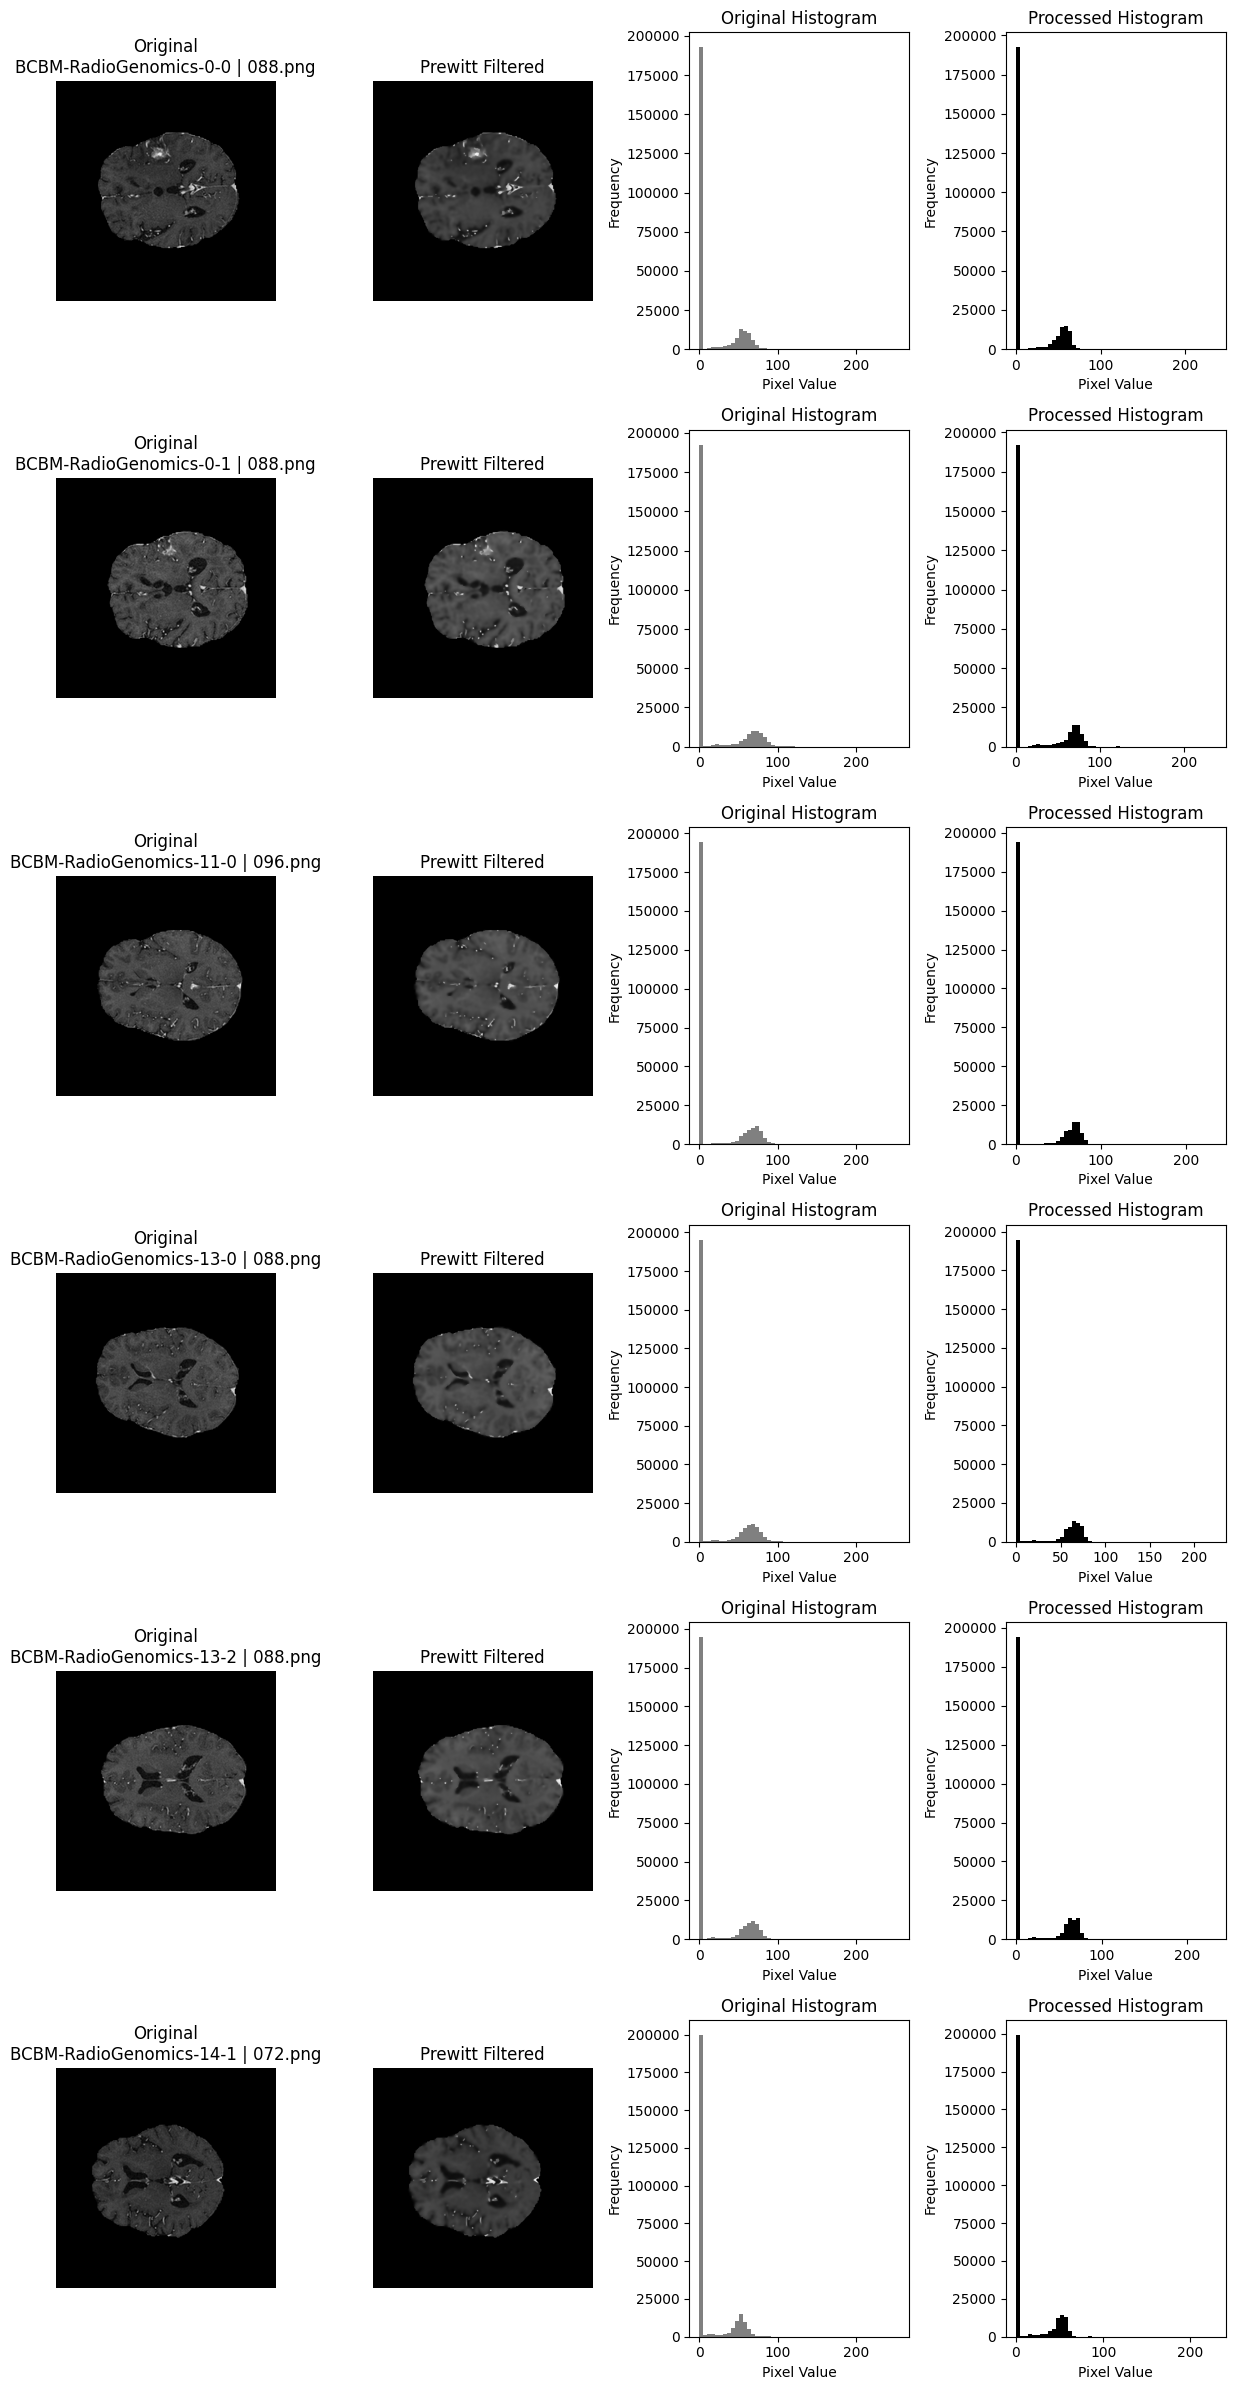

In [ ]:
# Visualization:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

def show_processed_comparison_with_histograms(original_root, processed_root, num_samples=6):

    # Pick patients
    patients = sorted(os.listdir(original_root))
    patients = [p for p in patients if os.path.isdir(os.path.join(original_root, p))]

    plt.figure(figsize=(12, 4 * num_samples))

    count = 0
    for patient in patients:
        if count >= num_samples:
            break

        orig_mri = os.path.join(original_root, patient, "MRI")
        processed_mri = os.path.join(processed_root, patient, "MRI")

        if not os.path.isdir(orig_mri):
            continue

        slices = sorted([f for f in os.listdir(orig_mri) if f.lower().endswith(".png")])
        if len(slices) == 0:
            continue

        # pick a middle slice for reproducibility
        slice_name = slices[len(slices)//2]
        orig_slice_path = os.path.join(orig_mri, slice_name)
        processed_slice_path  = os.path.join(processed_mri, slice_name)

        # load images
        orig_img = np.array(Image.open(orig_slice_path).convert("L"))
        processed_img   = np.array(Image.open(processed_slice_path).convert("L"))

        # PLOT IMAGES
        # Original MRI
        plt.subplot(num_samples, 4, 4 * count + 1)
        plt.imshow(orig_img, cmap='gray')
        plt.title(f"Original\n{patient} | {slice_name}")
        plt.axis("off")

        # Processed MRI
        plt.subplot(num_samples, 4, 4 * count + 2)
        plt.imshow(processed_img, cmap='gray')
        plt.title("Prewitt Filtered")
        plt.axis("off")

        # HISTOGRAMS
        # Histogram of original image
        plt.subplot(num_samples, 4, 4 * count + 3)
        plt.hist(orig_img.flatten(), bins=50, color='gray')
        plt.title("Original Histogram")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")

        # Histogram of HE image
        plt.subplot(num_samples, 4, 4 * count + 4)
        plt.hist(processed_img.flatten(), bins=50, color='black')
        plt.title("Processed Histogram")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")

        count += 1

    plt.tight_layout()
    plt.show()


# CALL VISUALIZER
original_dataset = "/content/drive/MyDrive/Dataset/Processed_2D_dataset_split/Train"
processed_dataset = "/content/drive/MyDrive/Dataset/Processed_2D_dataset_split/Train_Prewitt_filter"

show_processed_comparison_with_histograms(original_dataset, processed_dataset, num_samples=6)


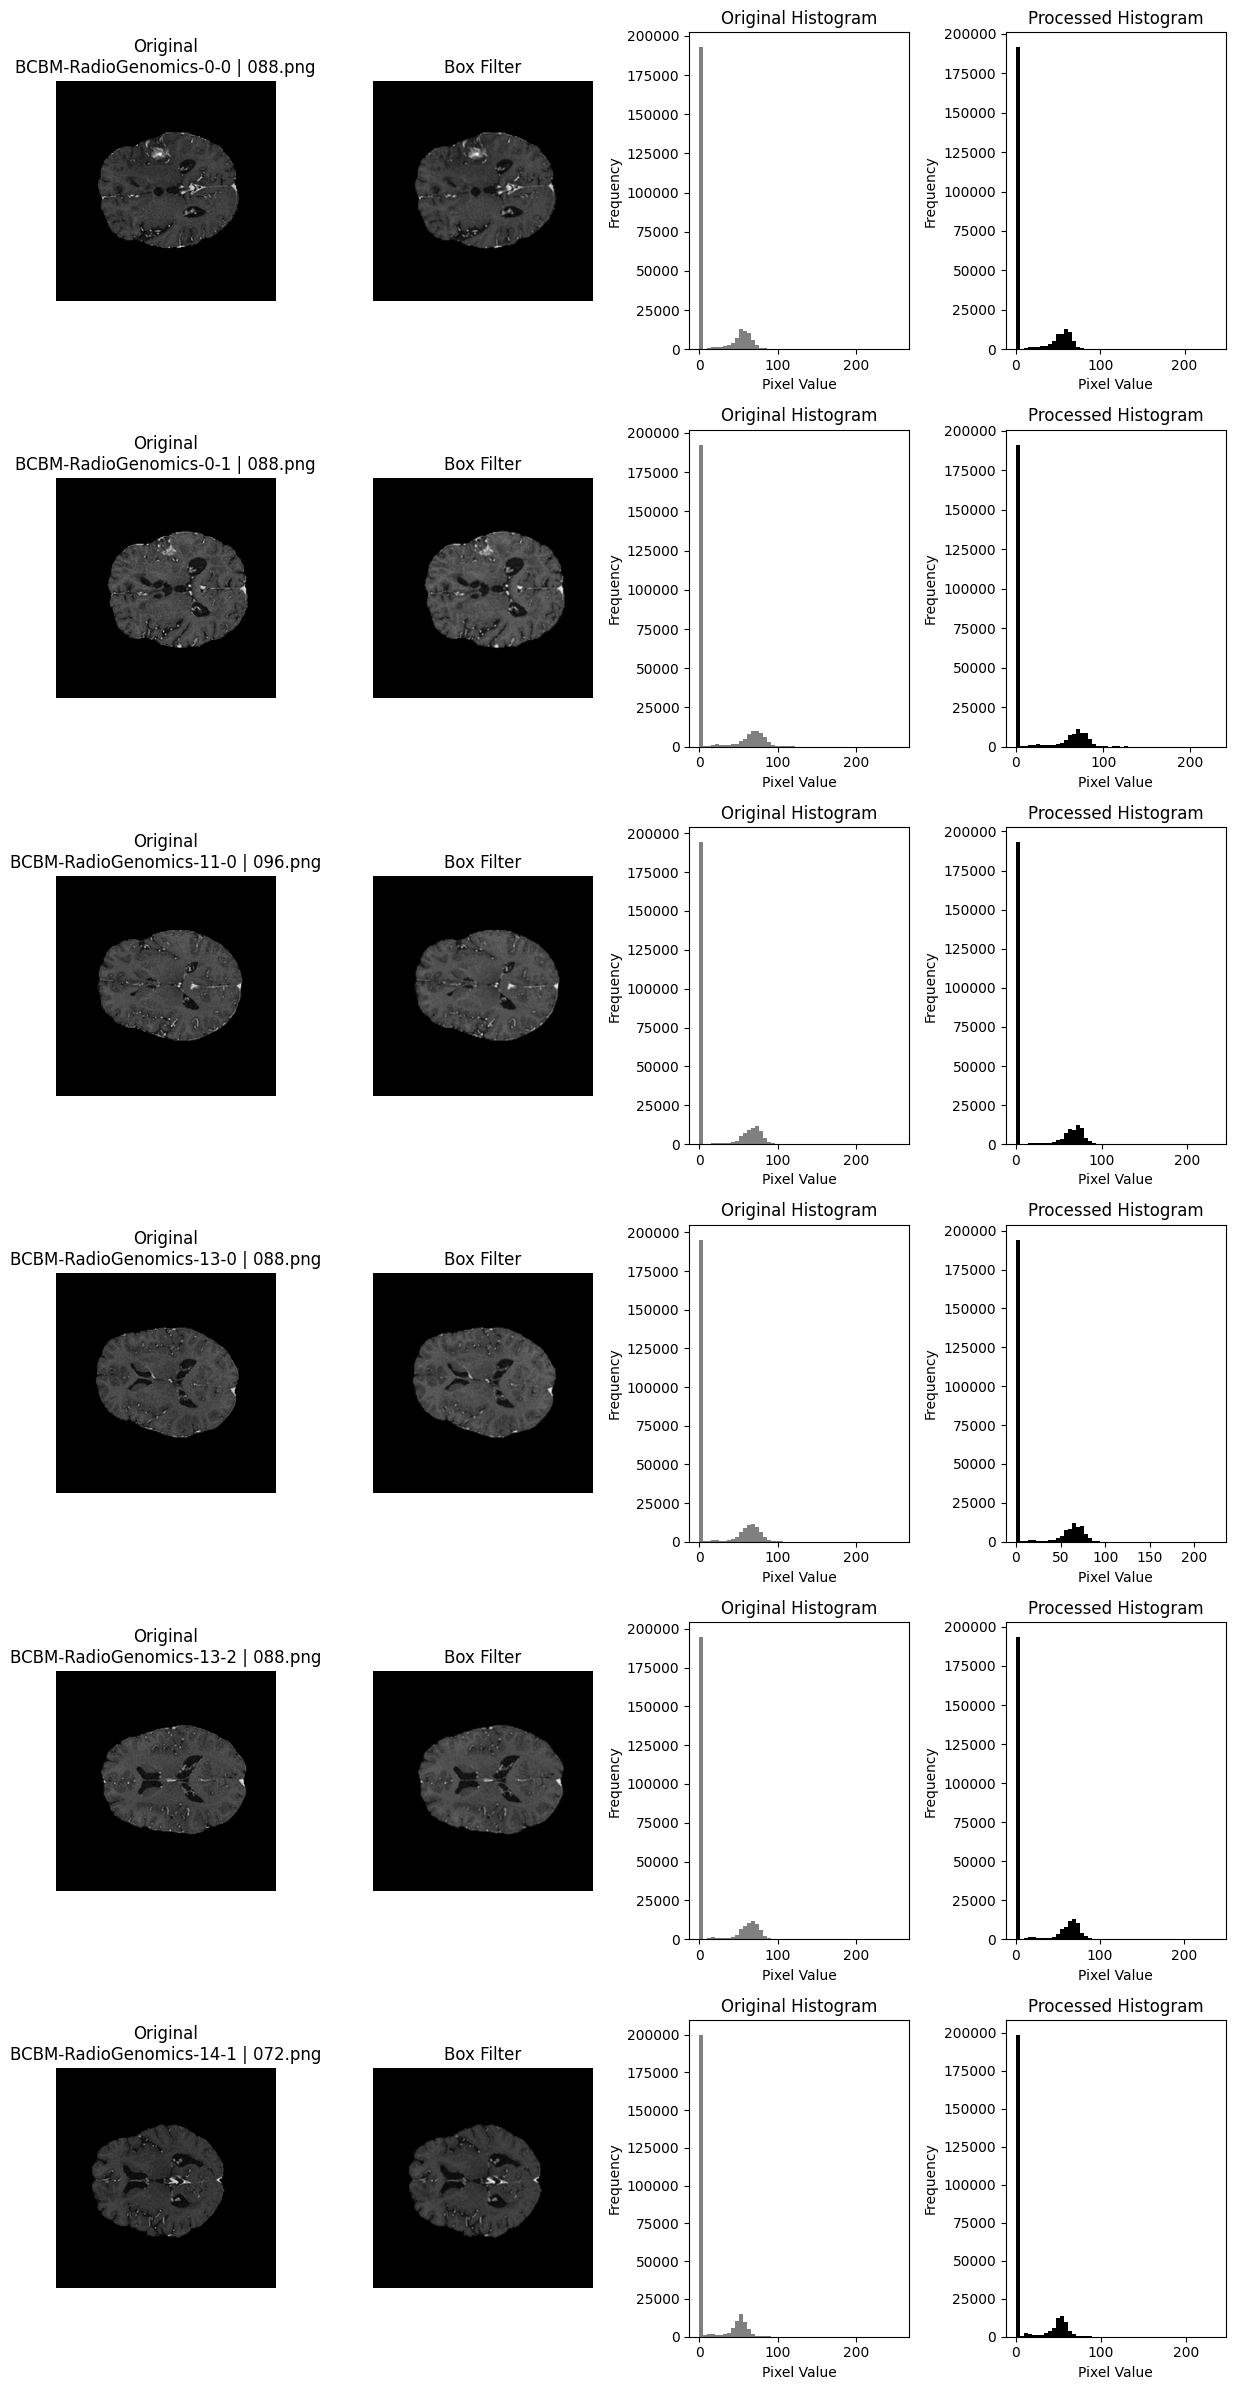

In [ ]:
# Visualization:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

def show_processed_comparison_with_histograms(original_root, processed_root, num_samples=6):

    # Pick patients
    patients = sorted(os.listdir(original_root))
    patients = [p for p in patients if os.path.isdir(os.path.join(original_root, p))]

    plt.figure(figsize=(12, 4 * num_samples))

    count = 0
    for patient in patients:
        if count >= num_samples:
            break

        orig_mri = os.path.join(original_root, patient, "MRI")
        processed_mri = os.path.join(processed_root, patient, "MRI")

        if not os.path.isdir(orig_mri):
            continue

        slices = sorted([f for f in os.listdir(orig_mri) if f.lower().endswith(".png")])
        if len(slices) == 0:
            continue


        slice_name = slices[len(slices)//2]
        orig_slice_path = os.path.join(orig_mri, slice_name)
        processed_slice_path  = os.path.join(processed_mri, slice_name)


        orig_img = np.array(Image.open(orig_slice_path).convert("L"))
        processed_img   = np.array(Image.open(processed_slice_path).convert("L"))

        plt.subplot(num_samples, 4, 4 * count + 1)
        plt.imshow(orig_img, cmap='gray')
        plt.title(f"Original\n{patient} | {slice_name}")
        plt.axis("off")


        plt.subplot(num_samples, 4, 4 * count + 2)
        plt.imshow(processed_img, cmap='gray')
        plt.title("Box Filter")
        plt.axis("off")


        plt.subplot(num_samples, 4, 4 * count + 3)
        plt.hist(orig_img.flatten(), bins=50, color='gray')
        plt.title("Original Histogram")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")


        plt.subplot(num_samples, 4, 4 * count + 4)
        plt.hist(processed_img.flatten(), bins=50, color='black')
        plt.title("Processed Histogram")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")

        count += 1

    plt.tight_layout()
    plt.show()


# CALL VISUALIZER
original_dataset = "/content/drive/MyDrive/Dataset/Processed_2D_dataset_split/Train"
processed_dataset = "/content/drive/MyDrive/Dataset/Processed_2D_dataset_split/Train_Box_filter"

show_processed_comparison_with_histograms(original_dataset, processed_dataset, num_samples=6)


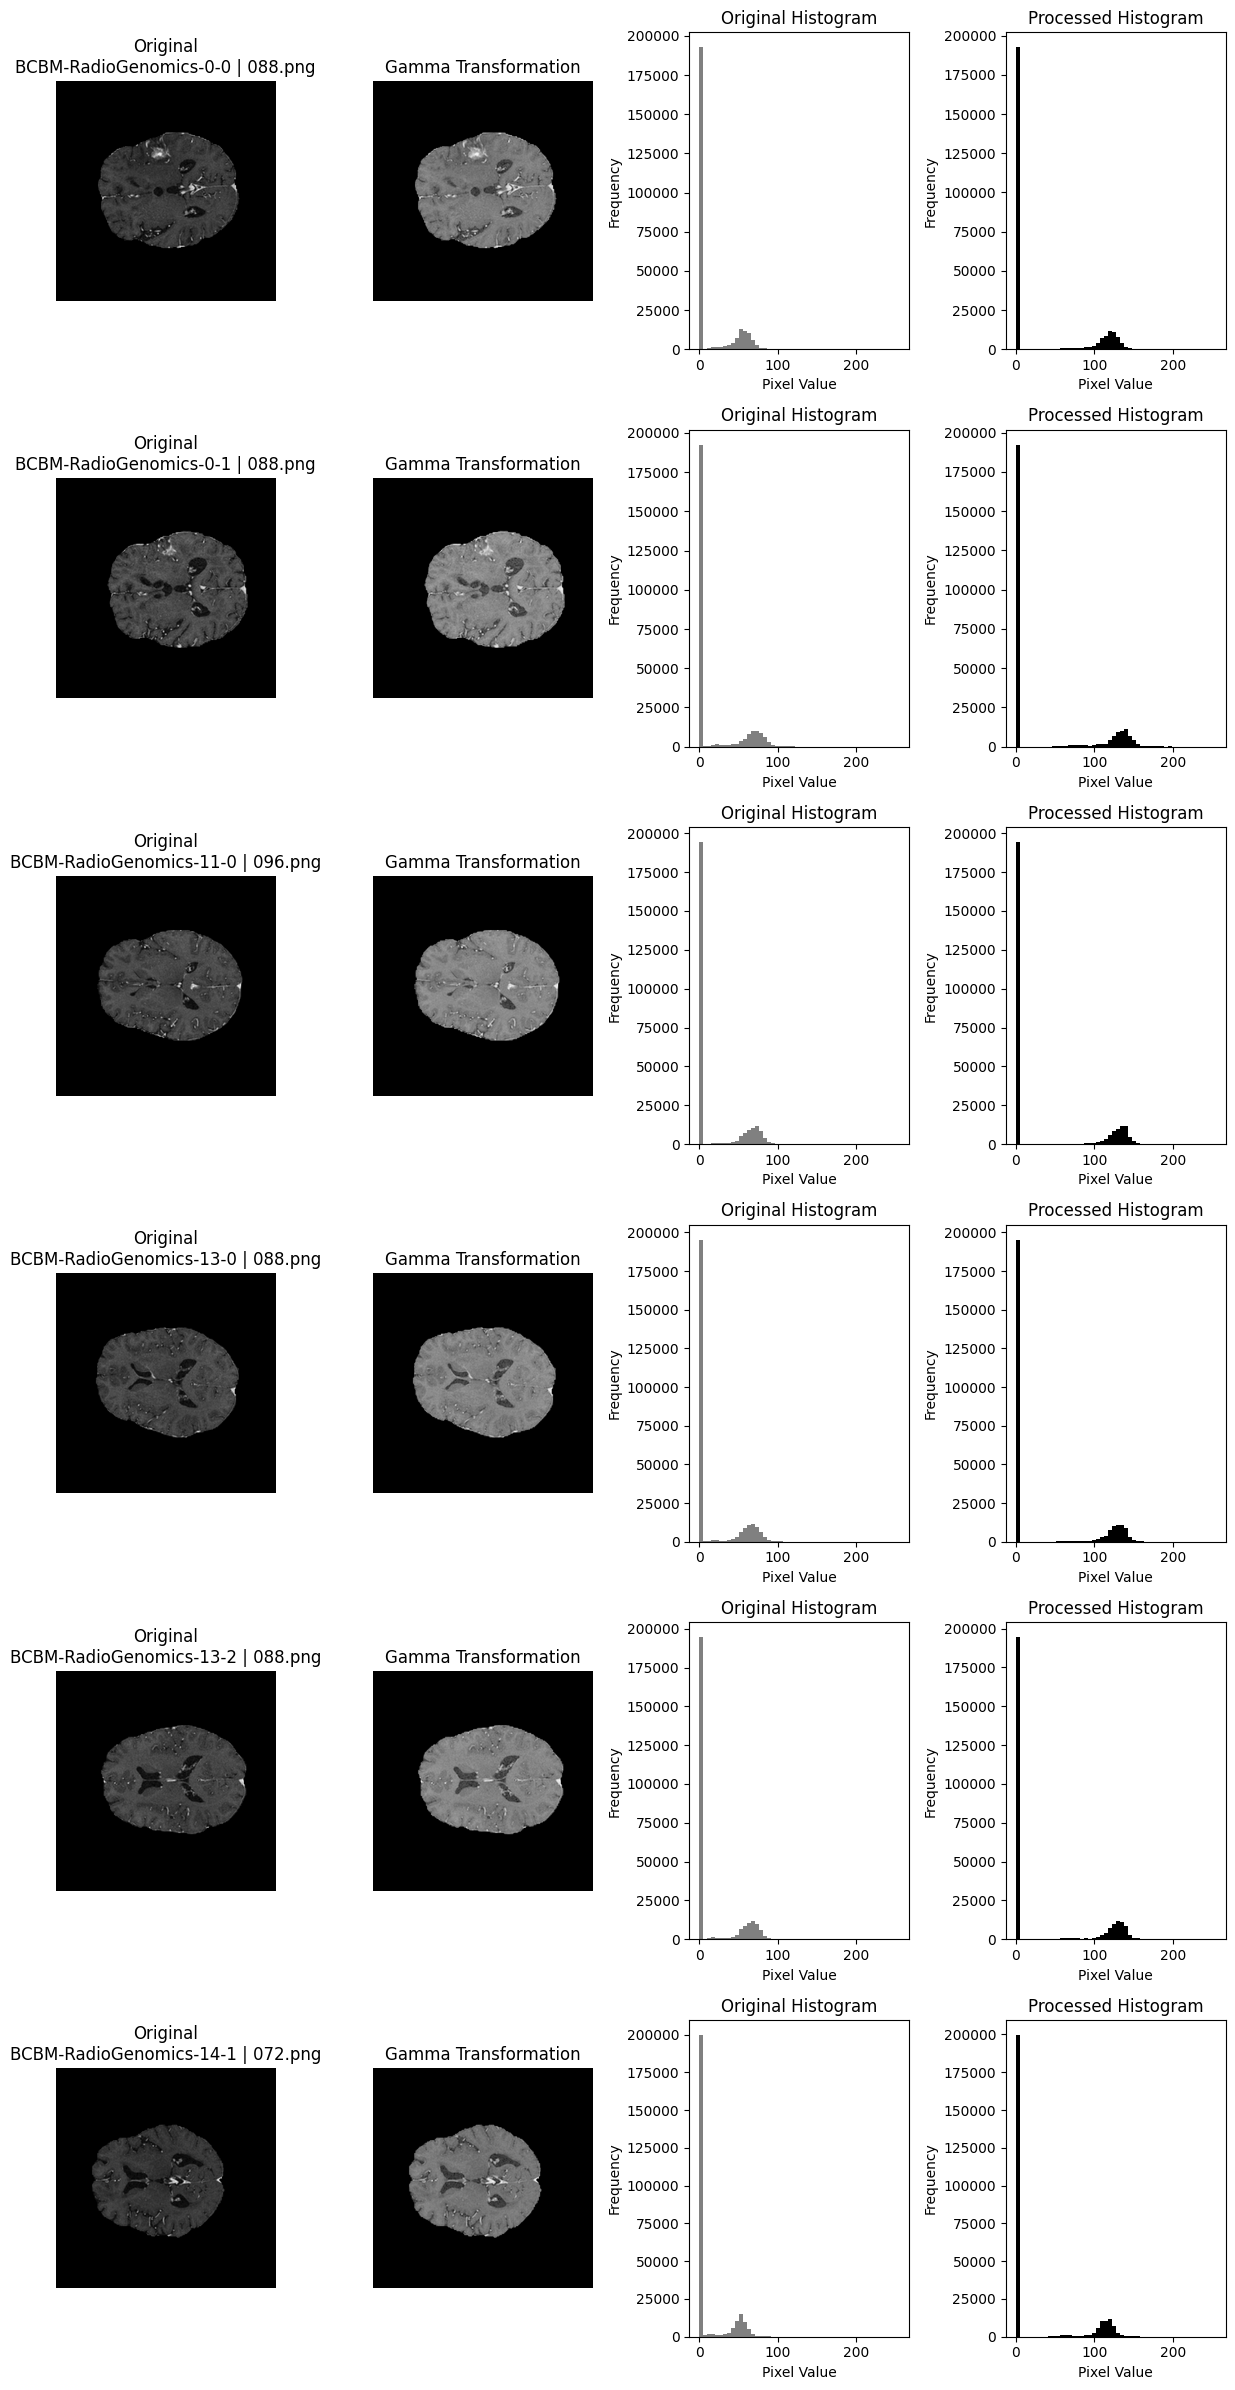

In [ ]:
# Visualization:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

def show_processed_comparison_with_histograms(original_root, processed_root, num_samples=6):

    # Pick patients
    patients = sorted(os.listdir(original_root))
    patients = [p for p in patients if os.path.isdir(os.path.join(original_root, p))]

    plt.figure(figsize=(12, 4 * num_samples))

    count = 0
    for patient in patients:
        if count >= num_samples:
            break

        orig_mri = os.path.join(original_root, patient, "MRI")
        processed_mri = os.path.join(processed_root, patient, "MRI")

        if not os.path.isdir(orig_mri):
            continue

        slices = sorted([f for f in os.listdir(orig_mri) if f.lower().endswith(".png")])
        if len(slices) == 0:
            continue


        slice_name = slices[len(slices)//2]
        orig_slice_path = os.path.join(orig_mri, slice_name)
        processed_slice_path  = os.path.join(processed_mri, slice_name)


        orig_img = np.array(Image.open(orig_slice_path).convert("L"))
        processed_img   = np.array(Image.open(processed_slice_path).convert("L"))


        plt.subplot(num_samples, 4, 4 * count + 1)
        plt.imshow(orig_img, cmap='gray')
        plt.title(f"Original\n{patient} | {slice_name}")
        plt.axis("off")


        plt.subplot(num_samples, 4, 4 * count + 2)
        plt.imshow(processed_img, cmap='gray')
        plt.title("Gamma Transformation")
        plt.axis("off")


        plt.subplot(num_samples, 4, 4 * count + 3)
        plt.hist(orig_img.flatten(), bins=50, color='gray')
        plt.title("Original Histogram")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")


        plt.subplot(num_samples, 4, 4 * count + 4)
        plt.hist(processed_img.flatten(), bins=50, color='black')
        plt.title("Processed Histogram")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")

        count += 1

    plt.tight_layout()
    plt.show()


# CALL VISUALIZER
original_dataset = "/content/drive/MyDrive/Dataset/Processed_2D_dataset_split/Train"
processed_dataset = "/content/drive/MyDrive/Dataset/Processed_2D_dataset_split/Train_Gamma_Transformation"

show_processed_comparison_with_histograms(original_dataset, processed_dataset, num_samples=6)
